In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Read data

In [3]:
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [4]:
locations = pd.read_csv("../assets/locations032017.csv", index_col=0)
locations.index = "V" + locations.index.astype(str)
locations.index.name = "device"
locations

,latitude,longitude
device,,
V1,1.306,103.920
V2,23.741,120.755
V3,25.073,121.536
V4,25.119,121.505
V5,25.056,121.552
...,...,...
V512,23.366,120.366
V513,22.954,120.244
V514,22.945,120.230


# 2. Seasonality check

<Axes: xlabel='hour'>

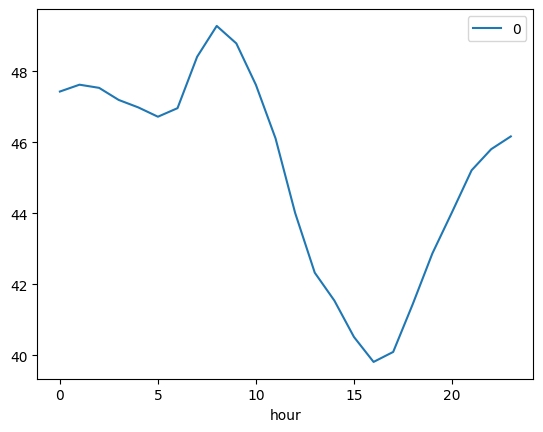

In [5]:
df.mean(axis = 1).to_frame().assign(
    hour = (np.arange(len(df)) % 24)
).groupby("hour").mean().plot()

<Axes: xlabel='hour', ylabel='pm25'>

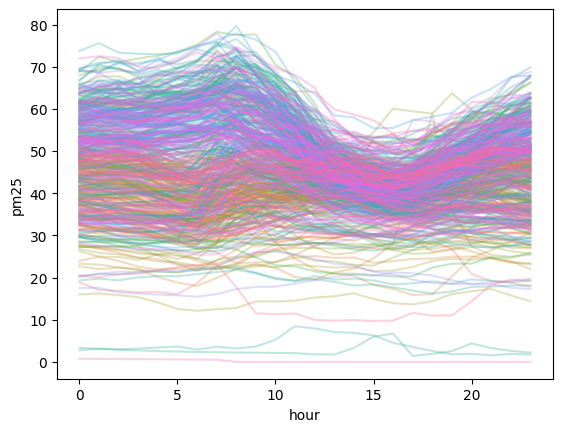

In [6]:
df_hour = df.assign(hour=(np.arange(len(df)) % 24))

sns.lineplot(
    data=df_hour
    .melt(id_vars=["hour"], var_name="device", value_name="pm25")
    .groupby(["hour", "device"])
    .mean(),
    x="hour",
    y="pm25",
    hue="device",
    legend=False,
    alpha=0.3,
)

In [29]:
# periodic spline to capture cyclical effect
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

N_SPLINES = 5 # if you use fewer than 8 you get a mean R^2 of below 9%

splines = periodic_spline_transformer(24, n_splines=N_SPLINES).fit_transform(df_hour[["hour"]])
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)

Text(0.5, 1.0, 'Periodic spline basis functions')

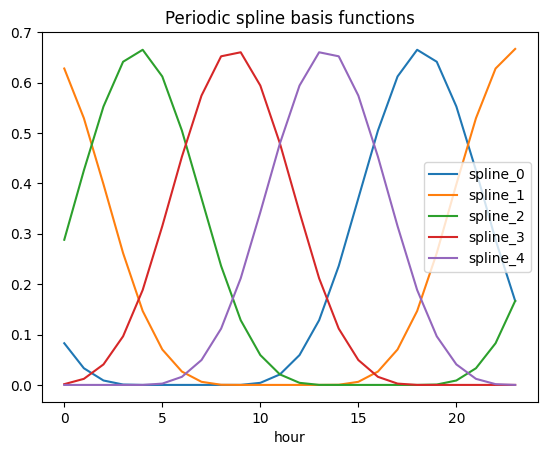

In [30]:
splines_df.assign(hour = df_hour["hour"]).groupby("hour").mean().plot()
plt.title("Periodic spline basis functions")

In [31]:
df_hour_spline = df_hour.merge(splines_df, how = "left", left_on = "hour", right_index = True).drop(columns = "hour")
df_hour_spline

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V512,V513,V514,V515,V516,spline_0,spline_1,spline_2,spline_3,spline_4
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,38.084488,44.854870,46.933081,45.600072,52.152083,0.166667,0.666667,0.166667,0.000000,0.000000
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,38.463276,45.044264,46.254293,45.387951,51.495833,0.082694,0.627785,0.288014,0.001507,0.000000
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,38.384003,45.359416,45.830051,45.212193,51.370833,0.033083,0.529225,0.425637,0.012056,0.000000
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,38.954315,45.789719,45.850253,45.290981,51.386458,0.008789,0.398112,0.552409,0.040690,0.000000
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,39.820982,46.716991,45.994192,45.903860,51.488542,0.000772,0.261574,0.641204,0.096451,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,34.142857,40.800000,32.375000,33.500000,35.000000,0.664967,0.146689,0.000000,0.000012,0.188332
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,31.500000,38.166667,32.000000,34.500000,37.500000,0.641204,0.261574,0.000772,0.000000,0.096451
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,19.000000,35.428571,30.333333,34.222222,35.333333,0.552409,0.398112,0.008789,0.000000,0.040690


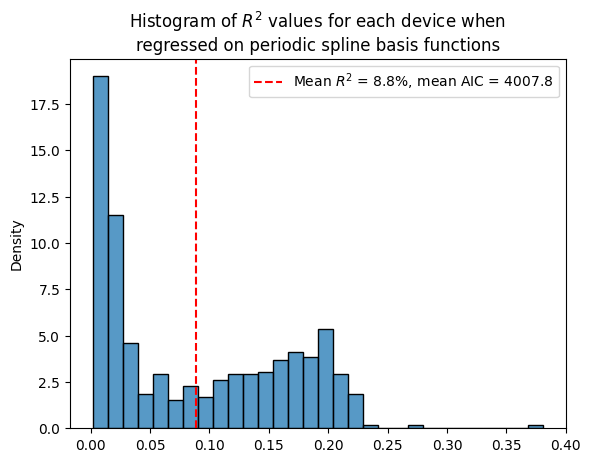

In [32]:
from sklearn.linear_model import RidgeCV

r2s = []
residuals = []
aics = []
for target_col in df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")]:
    # get ridgecv r^2
    ridgecv = RidgeCV()
    ridgecv.fit(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col])
    r2s.append(ridgecv.score(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col]))
    # get residuals
    predictions = ridgecv.predict(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]])
    residual = df_hour_spline[target_col]  - predictions
    residuals.append(residual)
    #residuals.append(df_hour_spline[target_col] - ridgecv.predict(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]]))
    # get aic
    # calculate and store AIC
    n = len(df_hour_spline)
    k = N_SPLINES
    rss = np.sum(residual**2)
    aic = n * np.log(rss/n) + 2 * k
    aics.append(aic)




r2s = pd.Series(r2s, index = df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")])
sns.histplot(r2s, bins = 30, stat = "density")
plt.title("Histogram of $R^2$ values for each device when\nregressed on periodic spline basis functions")
plt.axvline(r2s.mean(), color = "red", linestyle = "--", label = f"Mean $R^2$ = {r2s.mean() * 100:.1f}%, mean AIC = {np.mean(aics):.1f}")
plt.legend()

In [ ]:
residuals = pd.concat(residuals, axis = 1)
residuals

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,-22.342832,-3.116569,12.147587,2.659497,10.737338,7.930670,2.800332,5.890678,2.872822,5.581776,...,-14.639870,-1.024441,-17.414831,6.375465,-2.754792,-13.686524,-24.762748,-6.537448,-14.835954,-5.670398
2,-22.447433,-2.208705,10.809812,3.628737,10.438359,8.059212,4.797791,5.813972,3.246011,5.722668,...,-15.847779,-1.152319,-17.571162,4.909366,-3.189149,-13.681211,-25.443750,-8.145030,-15.763122,-6.063524
3,-22.676677,-1.477576,10.085036,4.815748,10.237478,7.903625,6.906874,5.945606,3.742143,6.139650,...,-16.369754,-1.402616,-16.728134,4.116709,-3.347336,-13.833561,-25.018517,-8.982367,-16.086097,-5.791371
4,-23.213525,-0.712179,9.870592,5.843948,10.169824,7.620348,7.438284,6.418208,4.053334,6.485583,...,-17.287671,-1.863507,-15.929542,4.037687,-3.393138,-13.273144,-24.296145,-9.164285,-16.087269,-5.721641
5,-23.731821,0.025469,9.695665,6.415877,10.125308,7.403772,7.801752,7.117694,4.440462,6.741828,...,-18.447805,-3.035762,-16.019500,4.445259,-3.466644,-12.530188,-23.495740,-9.257924,-15.850306,-6.221767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,17.083241,-30.182601,-27.858532,-34.156037,-33.964762,-32.256065,-30.243953,-31.774329,-31.944790,-37.305876,...,-16.694303,-10.125995,-13.974556,-10.676155,-13.005027,-12.207586,-13.308802,-11.471848,-16.863572,-17.216146
741,17.867075,-24.785405,-26.748385,-32.923775,-32.823620,-31.162104,-30.127614,-30.392634,-31.023014,-36.432742,...,-14.393872,-12.129205,-18.556645,-17.382790,-13.930290,-15.864623,-18.805135,-13.626348,-17.779144,-16.362235
742,16.935124,-21.773259,-27.914197,-34.602082,-33.770105,-1.014781,-30.457866,-30.396943,-33.260779,-37.035613,...,-19.065959,-12.222246,-21.348362,-21.493622,-17.901365,-29.529373,-24.783487,-17.248348,-20.093464,-20.157052


Text(0.5, 1.0, 'Mean residual for each hour of the day')

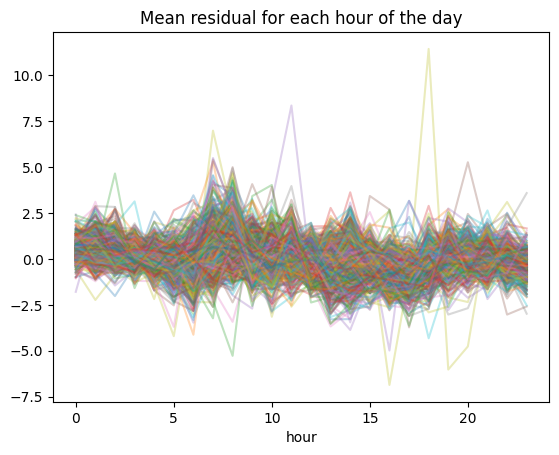

In [ ]:
residuals.assign(
    hour = (np.arange(len(df)) % 24)
).groupby("hour").mean().plot(legend = False, alpha = 0.3) 
plt.title("Mean residual for each hour of the day")


We notice seasonality is gone.

<Axes: ylabel='Count'>

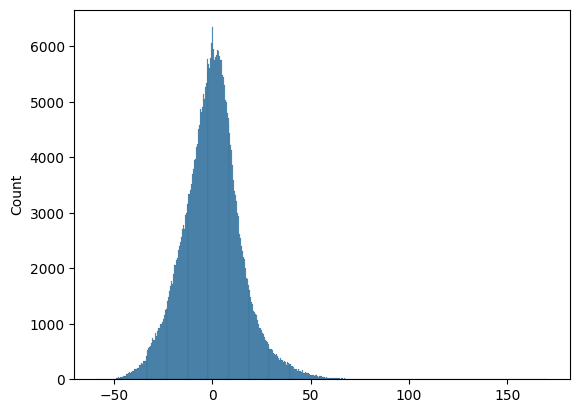

In [ ]:
sns.histplot(np.ravel(residuals))

<Axes: >

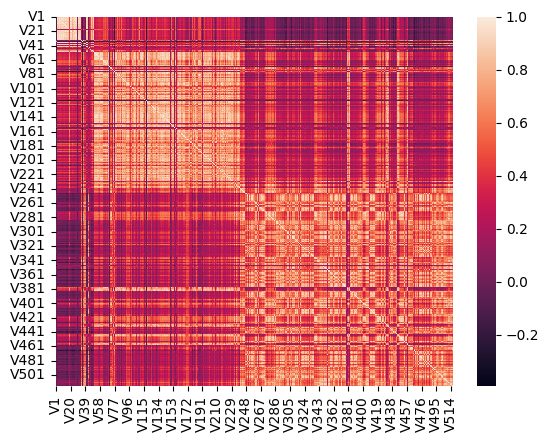

In [ ]:
# get corr
corr = residuals.corr()
sns.heatmap(corr)

<Axes: xlabel='day'>

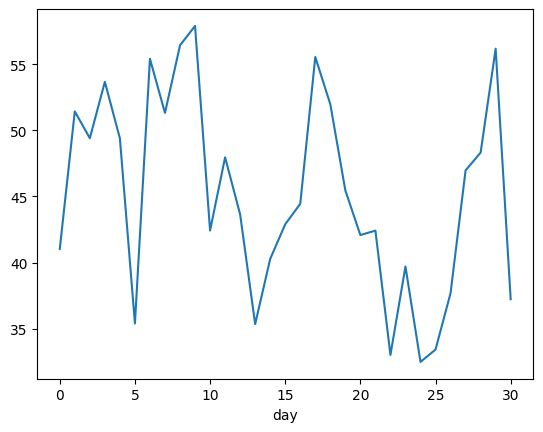

In [ ]:
df.assign(
    day = (np.arange(len(df)) // 24)
).groupby("day").mean().mean(axis = 1).plot()

<Axes: xlabel='day_of_week'>

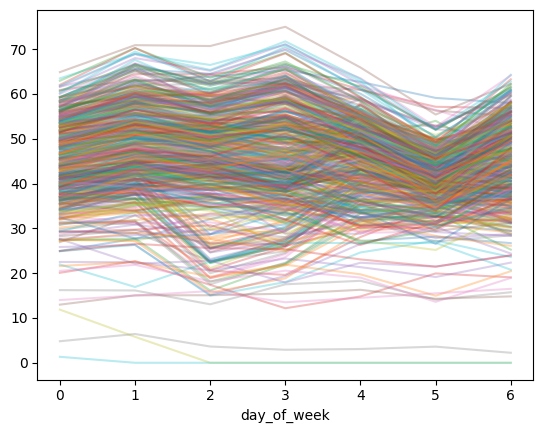

In [ ]:
df.assign(
    day = (np.arange(len(df)) // 24)
).assign(
    day_of_week = lambda x: x["day"] % 7
).groupby("day_of_week").mean().plot(alpha = 0.3, legend = False)